# Tesis

Este es el cuaderno de Jupyter para la implementación de la tesis. <br >
Este código utiliza el trabajo realizado por Diego Gomez (Poner aquí link al artículo de el, o el github o lo que sea) y lo aplica al problema de la regulación del nivel de glucosa en la sangre en pacientes Diabéticos Tipo 1. <br >
Se utiliza la librería de "simglucose" que permite simular la dinámica de la glucosa, de acuerdo con el simulador aprobado por la FDA de UVa/Padova (Versión 2008). <br >
Link de la librería de simglucose: https://github.com/jxx123/simglucose <br >
Link del GitHub de Diego: https://github.com/tarod13 <br >

# Tareas
1. Entender bien la librería de simglucose: rewards, acciones, estados, todo eso. (En progreso: ~5%) 
2. Hacer lo del mapeo de estados a acciones: s->a (En progreso: ~80%)
3. Hacer lo del mapeo de estados a Habilidades: s->A (Sin comenzar: 0%)
4. Implementar lo de Diego para encontrar los conceptos: s->S (Sin comenzar: 0%)
5. Analizar todo

In [1]:
import time, copy, random, datetime
import numpy as np
import cupy as cp
import pandas as pd
from collections import deque

import progressbar
import gym
import simglucose

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers.normalization import BatchNormalization
from keras import optimizers
from keras.initializers import RandomNormal
from keras.models import load_model
%matplotlib inline
import matplotlib.pyplot as plt

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

/home/hero/tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/hero/tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/hero/tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/hero/tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (

In [2]:
class ExperienceReplay():
    def __init__(self, tamano_minimo = 1000, tamano_maximo = 10**5, tamano_batch = 32, column_names = ['St', 'At', 'St+1', 'Rt+1', 'done']):
        self.tamano_buffer = 0
        self.indice = 0
        self.tamano_batch = tamano_batch
        self.tamano_minimo = tamano_minimo
        self.tamano_maximo = tamano_maximo
        self.columnas = column_names
        
        self.buffer = self.inicializarBuffer()
        self.buffer.columns = column_names
        #self.indices = range(self.tamano_maximo)
    
    def inicializarBuffer(self):
        aux = pd.DataFrame(np.zeros((10**4,5)), dtype = 'object')
        #aux = pd.DataFrame({'St': None, 'At': [np.array([0,0])],
        #                   'Rt+1': [np.array([0,0])], 'St+1': [np.array([0,0])],
        #                   'done': [np.array([0,0])]})
        
        buffer = []
        
        for i in range(int(self.tamano_maximo/10**4)):
            buffer.append(aux)
        
        return pd.concat(buffer)
    
    def agregarDato(self, x, a, r, xp, d):
        
        if(self.indice == self.tamano_maximo):
            self.indice = 0
            
        self.buffer.iloc[self.indice]['St'] = x
        self.buffer.iloc[self.indice]['At'] = a
        self.buffer.iloc[self.indice]['Rt+1'] = r
        self.buffer.iloc[self.indice]['St+1'] = xp
        self.buffer.iloc[self.indice]['done'] = d

        self.indice +=1
        
        if self.tamano_buffer < self.tamano_maximo:
            self.tamano_buffer += 1
    
    def darMuestras(self):
        #indices = random.sample(self.indices[0:self.tamano_buffer], self.tamano_batch)
        indices = random.sample(range(self.tamano_buffer), self.tamano_batch)
        return self.buffer.iloc[indices]

In [3]:
# Codigo tomado de: https://github.com/jxx123/simglucose

# Basal: Largo plazo
# Bolus: Corto plazo

# Register gym environment. By specifying kwargs,
# you are able to choose which patient to simulate.
# patient_name must be 'adolescent#001' to 'adolescent#010',
# or 'adult#001' to 'adult#010', or 'child#001' to 'child#010'

#Cada vez que se crea un env se construye de manera aleatoria
#Por ejemplo, la cantidad de carbohidratos que se consumen y 
#el tiempo en el que se consumen es aleatoria.

def calcular_risk(bg):
    fBG = 1.509*((np.log(bg))**1.084 - 5.381)
    
    rBG = 10*(fBG**2)
    
    rlBG = rBG*(fBG < 0)
    rhBG = rBG*(fBG > 0)
    
    LBGI, HBGI = rlBG, rhBG
    
    risk = LBGI + HBGI
    
    return risk

def custom_reward(BG_last_hour):
    
    if BG_last_hour[-1] > 39:#and BG_last_hour[-1] < 250:
        
        risk_t = calcular_risk(BG_last_hour[-1])
        risk_t_1 = calcular_risk(BG_last_hour[-2])
        
        reward = risk_t_1-risk_t
    else:
        reward = -10
    
    return reward

def custom_reward_2(BG_last_hour):
    #    if BG_last_hour[-1] > 39:#and BG_last_hour[-1] < 250:
        
    alpha = 0.5
    beta = 1
    
    if BG_last_hour[-1] > 39:#and BG_last_hour[-1] < 250:
        risk_t = calcular_risk(BG_last_hour[-1])
        risk_t_1 = calcular_risk(BG_last_hour[-2])

        reward = -alpha*risk_t + beta*(risk_t_1-risk_t)
    else:
        reward = -25
    
    #else:
    #    reward = -10
    
    return reward
    
from gym.envs.registration import register
register(
    id='simglucose-adult2-v0',
    entry_point='simglucose.envs:T1DSimEnv',
    kwargs={'patient_name': 'adult#002', 'reward_fun': custom_reward_2}
)

In [4]:
bg = [70, 60]

print(custom_reward(bg))
print(custom_reward_2(bg))

-5.8153968009369965
-12.600697986710218


In [7]:
%timeit custom_reward(np.array([90, 80]))

20 µs ± 227 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [5]:
#Creando redes neuronales

def crearRedes(num_entrada, num_salida, n1 = 256, n2 = 256, learning_rate = 0.01, grad_clip = 0.001):
    init = RandomNormal(seed = 0)
    
    modelo = Sequential()
    
    modelo.add(Dense(n1, activation = 'relu', kernel_initializer = init, bias_initializer = init, input_dim = num_entrada))
    modelo.add(BatchNormalization())
    modelo.add(Dense(n2, activation = 'relu', kernel_initializer = init, bias_initializer = init))
    #modelo.add(Dense(n2, activation = 'relu', kernel_initializer = init, bias_initializer = init))
    modelo.add(BatchNormalization())
    modelo.add(Dense(num_salida, activation = 'linear', kernel_initializer = init, bias_initializer = init))
    
    #sgd = optimizers.sgd(lr = learning_rate)
    adam = optimizers.adam(lr = learning_rate, clipnorm = grad_clip)
    modelo.compile(loss = 'mean_squared_error', optimizer = adam, metrics = ['accuracy'])
    
    return modelo, copy.deepcopy(modelo)

def actualizarRedTarget(pRedPrincipal, pRedTarget):
    
    for i in range(len(pRedPrincipal.layers)):
        pesosPrincipal = pRedPrincipal.layers[i].get_weights()
        pesosTarget = pRedTarget.layers[i].get_weights()
        
        pesos = [tao*l1 + (1-tao)*l2 for l1, l2 in zip(pesosPrincipal, pesosTarget)]
        
        pRedTarget.layers[i].set_weights(pesos)

def escogerAccion(pModelo, pX, pNumAcciones):
    num = np.random.random()
    
    if(num <= epsilon):
        ind = np.random.randint(0, pNumAcciones)
        return ind
    else:
        #Esto creo que es como lento. Hacerlo mejor.
        #Usando deque:
        x = np.reshape(np.asarray(pX), (1,-1))
        ind = np.argmax(pModelo.predict(x))
        return ind
    
def convertirAccion(pAccion, pMaxAccion, pNumAcciones):
    return pAccion*pMaxAccion/float(pNumAcciones)

envName = 'simglucose-adult2-v0'

In [5]:
0.9998**10000

0.13530821527775996

# Entrenamiento con Estado de Ventana de Tiempo

In [5]:
np.random.seed(123)

env = gym.make(envName)

num_episodes = 10000
num_steps = 200
num_steps_train = 10
epsilon = 1.0
epsilon_decay = 0.9998
tao = 0.001
gamma = 0.99
batch_size = 128

total_steps_log = []
epsilon_log = []
muestras_log = []
rewards_acumulados = []
rewards_promedio = []
cantidad_steps_log = []

buffer = ExperienceReplay(tamano_minimo = 100, tamano_batch = batch_size)

num_estados = 60
max_estados = num_estados

num_acciones = 30
max_accion = 30.0
max_glucosa = 200.0
max_cho = 30
max_norm = [1/max_glucosa, 1/max_accion, 1/max_cho]

reward_done = -1
render = False

red, red_target = crearRedes(learning_rate = 0.01, num_entrada = num_estados*3, num_salida = num_acciones)

observation = env.reset()

state_queue = deque([[observation[0], 0.0, 0.0]]*num_estados , maxlen = num_estados)

initial_time = time.time()
    
with progressbar.ProgressBar(max_value = buffer.tamano_minimo) as bar:
    s = 0
    while s < buffer.tamano_minimo:
    
        #if False:
        #    action = 0.0
            
        #    i = 0
            
        #    while i < max_estados:
        #        observation, reward, done, info = env.step(action)
                
        #        state_queue.append([observation[0], action, info['meal']])
                
        #        i+=1
                
        state = np.array(state_queue)*max_norm
        state = np.reshape(state, (1,-1))
        action = np.random.randint(num_acciones)

        observation, reward, done, info = env.step(convertirAccion(action, max_accion, num_acciones))
        
        state_queue.append([observation[0], action, info['meal']])
        
        next_state = np.array(state_queue)*max_norm
        next_state = np.reshape(next_state, (1,-1))

        if done and reward == -10:
            env = gym.make(envName)
            state_queue.clear()
            observation = env.reset()
            state_queue = deque([[observation[0], 0.0, 0.0]]*num_estados , maxlen = num_estados)
        else:
            buffer.agregarDato(copy.copy(state), action, reward, copy.copy(next_state), done)

        s+=1
        bar.update(s)

for e in progressbar.progressbar(range(num_episodes)):
    env = gym.make(envName)
    
    state_queue.clear()
    
    observation = env.reset()
    state_queue = deque([[observation[0], 0.0, 0.0]]*num_estados , maxlen = num_estados)

    rewardAcumulado = 0
    cantidad_steps = num_steps
    
    s = 0
    while s < num_steps:
        
        if render:
            env.render(mode = "human")
        
        #if False:
        #    action = 0.0

        #    i = 0
        #    while i < max_estados:
        #        observation, reward, done, info = env.step(action)
                
        #        state_queue.append([observation[0], action, info['meal']])
                
        #        i+=1
            
        #    s+=max_estados
        
        if(np.random.random() <= epsilon):
            action = np.random.randint(num_acciones)
        else:
            action = np.argmax(red.predict(state))
            
        state = np.array(state_queue)*max_norm
        state = np.reshape(state, (1,-1))
        
        observation, reward, done, info = env.step(convertirAccion(action, max_accion, num_acciones))
        
        state_queue.append([observation[0], action, info['meal']])
        
        next_state = np.array(state_queue)*max_norm
        next_state = np.reshape(next_state, (1,-1))

        rewardAcumulado += reward
        
        s+=1
        
        if done and reward == -10:
            cantidad_steps = s
            break
        else:
            buffer.agregarDato(copy.copy(state), action, reward, copy.copy(next_state), done)
    
    suma_muestras = 0
    i = 0
    while i < num_steps_train:
        
        tm = time.time()
        muestras = buffer.darMuestras()
        suma_muestras += time.time()-tm

        states = np.concatenate(muestras['St'].values)
        
        actions = muestras['At'].values
        rewards = muestras['Rt+1'].values
        
        next_states = np.concatenate(muestras['St+1'].values)
        
        #dones = muestras['done'].values
        
        Q_values = red.predict(states)
        
        next_Q_values = red_target.predict(next_states)
        targets = Q_values.copy()

        targets[np.arange(buffer.tamano_batch), list(actions)] = rewards + gamma* np.max(next_Q_values, axis = 1)# * (1 - dones)

        red.train_on_batch(states, targets)

        actualizarRedTarget(red, red_target)
        
        i+=1
        
    suma_muestras *= 1/(cantidad_steps+1)
    muestras_log.append(suma_muestras)
    rewards_acumulados.append(rewardAcumulado)
    rewards_promedio.append(rewardAcumulado/cantidad_steps)
    
    total_steps_log.append(s)
    cantidad_steps_log.append(cantidad_steps)
    epsilon_log.append(epsilon)
    epsilon = epsilon_decay * epsilon

total_training_time = time.time() - initial_time

plt.figure(figsize=(10,4))

plt.subplot(121)
plt.plot(muestras_log)
plt.xlabel('Episode')
plt.ylabel('Tiempo Muestra (seg)')
plt.show()

plt.subplot(122)
plt.plot(epsilon_log)
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.show()

plt.figure(figsize=(10,4))

plt.subplot(121)
plt.plot(rewards_acumulados, color = 'b', label = "Reward Acumulado")
#plt.plot(rewards_promedio, color = 'r', label = "Reward Promedio")
plt.legend()
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

plt.subplot(122)
plt.plot(cantidad_steps_log)
plt.xlabel('Episode')
plt.ylabel('Cantidad Steps')
plt.show()

print('Total training time: ', np.round(total_training_time, 2), 'seconds')

/home/hero/tf/lib/python3.6/site-packages/gym/envs/registration.py:17: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


RuntimeError: It looks like you are trying to use a version of multi-backend Keras that does not support TensorFlow 2.0. We recommend using `tf.keras`, or alternatively, downgrading to TensorFlow 1.14.

# Entrenamiento con Estado del Paciente

In [44]:
0.998**1000

0.13506452244668338

In [ ]:
np.random.seed(123)

env = gym.make(envName)

env_test = gym.make(envName)
num_steps_test = 300
rewards_acumulados_test = []
        
num_episodes = 1000
num_steps = 200
num_steps_train = 100
epsilon = 1.0
#epsilon_decay = 0.98
tao = 0.001
gamma = 0.99
batch_size = 128

total_steps_log = []
epsilon_log = []
muestras_log = []
rewards_acumulados = []
rewards_promedio = []
cantidad_steps_log = []

#buffer = ExperienceReplay(tamano_minimo = 128*4, tamano_batch = batch_size)
#buffer = np.zeros((100000, 29))
#Orden: St, At, Rt+1, St+1, done 

#tam_buffer = 0
min_buffer = 128*4

num_estados = 13
max_estados = 13
num_acciones = 30
max_accion = 30.0#30.0
max_glucosa = 200.0
max_cho = 30

max_norm = 1./np.array([68e3, 35e3, 41e3, 23e1, 10e1, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 23e1])

#max_norm = 1./np.array([68e3, 35e3, 41e3, 23e1, 10e1, 33e2, 75e3, 28e3, 67e2, 23e2, 56e3, 41e3, 23e1])

reward_done = -1
render = False

#red, red_target = crearRedes(learning_rate = 1e-3, grad_clip = 1, num_entrada = num_estados, num_salida = num_acciones)

observation = env.reset()
observation, reward, done, info = env.step(0.0)
state = np.reshape(info['patient_state'], (1, -1))*max_norm
#state = np.zeros((1, 13))

initial_time = time.time()
    
with progressbar.ProgressBar(max_value = min_buffer) as bar:
    s = 0
    while s < min_buffer:#buffer.tamano_minimo:

        action = np.random.randint(num_acciones)
        a = convertirAccion(action, max_accion, num_acciones)

        observation, reward, done, info = env.step(a)
        
        next_state = np.reshape(info['patient_state'], (1, -1))*max_norm

        #buffer.agregarDato(copy.copy(state), action, reward, copy.copy(next_state), done)
        buffer[tam_buffer, 0:13] = state
        buffer[tam_buffer, 13] = action
        buffer[tam_buffer, 14] = reward
        buffer[tam_buffer, 15:28] = next_state
        buffer[tam_buffer, 28] = done
        
        tam_buffer += 1

        bar.update(s)
        
        s+=1
        
        if done and reward == -25:
            env = gym.make(envName)
            observation = env.reset()
            observation, reward, done, info = env.step(0.0)
            state = np.reshape(info['patient_state'], (1, -1))*max_norm
            #state = np.zeros((1, 13))
        else:
            #buffer.agregarDato(copy.copy(state), action, reward, copy.copy(next_state), done)
            state = next_state
            
for e in progressbar.progressbar(range(num_episodes)):
    env = gym.make(envName)
    
    observation = env.reset()
    observation, reward, done, info = env.step(0.0)
    state = np.reshape(info['patient_state'], (1, -1))*max_norm
    #state = np.zeros((1, 13))
    
    #rewardAcumulado = 0
    reward_test = 0
    cantidad_steps = num_steps
    
    s = 0
    while s < num_steps:
        
        if render:
            env.render(mode = "human")

        if(np.random.random() <= epsilon):
            action = np.random.randint(num_acciones)
        else:
            action = np.argmax(red.predict(state))
        
        a = convertirAccion(action, max_accion, num_acciones)
        observation, reward, done, info = env.step(a)
        
        next_state = np.reshape(info['patient_state'], (1, -1))*max_norm

        #rewardAcumulado += reward
        
        #buffer.agregarDato(copy.copy(state), action, reward, copy.copy(next_state), done)
        buffer[tam_buffer, 0:13] = state
        buffer[tam_buffer, 13] = action
        buffer[tam_buffer, 14] = reward
        buffer[tam_buffer, 15:28] = next_state
        buffer[tam_buffer, 28] = done
        
        tam_buffer+=1
        
        s+=1
        
        if done and reward == -25:
            cantidad_steps = s
            break
        else:
            #buffer.agregarDato(copy.copy(state), action, reward, copy.copy(next_state), done)
            state = next_state
    
    
    suma_muestras = 0
    i = 0
    while i < num_steps_train:
        
        #muestras = buffer.darMuestras()

        #states = np.concatenate(muestras['St'].values)
        
        #actions = muestras['At'].values
        #rewards = muestras['Rt+1'].values
        
        #next_states = np.concatenate(muestras['St+1'].values)
        
        indices = np.random.randint(0, tam_buffer, size = batch_size)

        states = buffer[indices, 0:13]
        actions = buffer[indices, 13].astype(int)
        rewards = buffer[indices, 14]
        next_states = buffer[indices, 15:28]
        dones = buffer[indices, 28]
        
        #suma_muestras += time.time()-tm
        
        Q_values = red.predict(states)
        
        next_Q_values = red_target.predict(next_states)
        targets = Q_values.copy()

        targets[np.arange(batch_size), list(actions)] = rewards + gamma* np.max(next_Q_values, axis = 1)

        red.train_on_batch(states, targets)

        actualizarRedTarget(red, red_target)
        
        i+=1
        
    #Se corre una vez en el de prueba para ver como ha mejorado. Esto no hace en todos los episodios.
    #Quizas se puede correr siempre?
    #Lo demorado es la parte de coger las muestras y renderizar, entonces yo creo que se puede en cada episodio
    #sin mucho tiempo adicional.
    
    if (e+1) % 5 == 0:
        
        tm = time.time()
        
        observation = env_test.reset()
        observation, reward, done, info = env_test.step(0.0)
        state = np.reshape(info['patient_state'], (1, -1))*max_norm

        reward_test = reward

        for s in range(num_steps_test):

            action = np.argmax(red.predict(state))

            a = convertirAccion(action, max_accion, num_acciones)

            observation, reward, done, info = env_test.step(a)
            state = np.reshape(info['patient_state'], (1, -1))*max_norm

            reward_test += reward
            
        rewards_acumulados_test.append(reward_test)
        muestras_log.append(time.time()-tm)
    
    suma_muestras *= 1/(cantidad_steps+1)
    #rewards_acumulados.append(rewardAcumulado)
    #rewards_promedio.append(rewardAcumulado/cantidad_steps)
    
    total_steps_log.append(s)
    cantidad_steps_log.append(cantidad_steps)
    epsilon_log.append(epsilon)
    #epsilon = epsilon_decay * epsilon
    epsilon = 1.0 - (0.9/num_episodes)*e 

total_training_time = time.time() - initial_time

plt.figure(figsize=(10,4))

plt.subplot(121)
plt.plot(muestras_log)
plt.xlabel('Episode')
plt.ylabel('Tiempo Muestra (seg)')
plt.show()

plt.subplot(122)
plt.plot(epsilon_log)
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.show()

plt.figure(figsize=(10,4))

plt.subplot(121)
#plt.plot(rewards_acumulados, color = 'b', label = "Reward Acumulado")
#plt.plot(rewards_promedio, color = 'r', label = "Reward Promedio")
plt.plot(rewards_acumulados_test, color = 'g', label = "Reward Acumulado Test")
plt.legend()
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

plt.subplot(122)
plt.plot(cantidad_steps_log)
plt.xlabel('Episode')
plt.ylabel('Cantidad Steps')
plt.show()

print('Total training time: ', np.round(total_training_time, 2), 'seconds')

100% (512 of 512) |######################| Elapsed Time: 0:00:08 Time:  0:00:08
  0% (7 of 1000) |                       | Elapsed Time: 0:00:16 ETA:   0:33:01

0


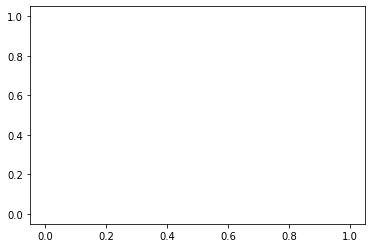

In [32]:
plt.plot(rewards_acumulados_test, color = 'r', label = "Reward Promedio")
print(reward_test)

In [58]:
tam_buffer

30461

# Probando el Agente

# Con Estado de Ventana de Tiempo

In [9]:
env = gym.make(envName)
observation = env.reset()

state_queue = deque([[observation[0], 0.0, 0.0]]*num_estados, maxlen = num_estados)
    
num_steps_test = 200

s = 0
rewards = []

for s in progressbar.progressbar(range(num_steps_test)):
    env.render(mode='human')
    
    state = np.array(state_queue)*max_norm
    state = np.reshape(state, (1,-1))
    
    action = np.argmax(red.predict(state))
    #action = 0.0
    
    observation, reward, done, info = env.step(action)
    state_queue.append([observation[0], action, info['meal']])
    rewards.append(reward)
    
    #if done:
        #print("Episode finished after {} timesteps".format(s + 1))
        #print(reward)
        #break

fig = plt.figure(2, (8,8))
plt.plot(rewards)

57.8 ns ± 0.0939 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


# Con Estado del Paciente

100% (300 of 300) |######################| Elapsed Time: 0:00:23 Time:  0:00:23


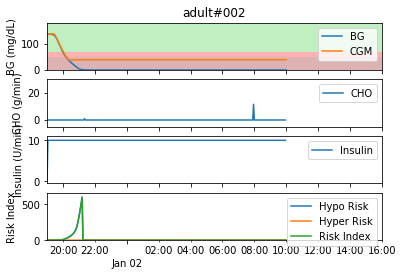

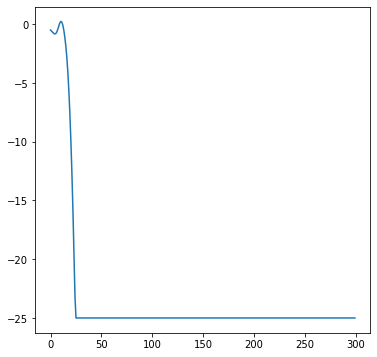

In [60]:
#Parece ser Glucosa: 3, 4, 12
#Parece ser CHO: 0, 1, 2, 
#Parece ser insulina: 5, 6, 7, 8, 9, 10, 11

#env = gym.make(envName)

observation = env_test.reset()
observation, reward, done, info = env_test.step(0.0)
state = np.reshape(info['patient_state'], (1, -1))*max_norm
    
num_steps_test = 300

s = 0
rewards = []
states = np.zeros((num_steps_test, 13))
counter = 0

for s in progressbar.progressbar(range(num_steps_test)):
    env_test.render(mode='human')
    states[s, :] = state
    
    action = np.argmax(red.predict(state))
    
    a = convertirAccion(action, max_accion, num_acciones)
    
    observation, reward, done, info = env_test.step(a)
    state = np.reshape(info['patient_state'], (1, -1))*max_norm
    rewards.append(reward)
    
    counter += 1
    
fig = plt.figure(2, (6,6))
plt.plot(rewards);

#fig = plt.figure(3, (8,8))
#plt.plot(states[:,0]);

In [61]:
observation = env.reset()
observation, reward, done, info = env.step(0.0)
state = np.reshape(info['patient_state'], (1, -1))*max_norm

print(state)
print(np.argmax(red.predict(state)))
print(red.predict(state))

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  9.94542548e-01
   1.05424335e+00  1.40710444e-01 -3.25232333e-04  3.56895932e+00
   3.56899991e+00  9.98992939e-02  2.05423766e+00  1.77395879e+00
   9.94542523e-01]]
10
[[ 1844.0928  7219.0923  6396.2886  9078.642   7480.7046  7894.413
   7901.7344  6523.354   7317.2427  6569.734  12077.141   7140.183
   7491.7593  7854.301   6914.944   6790.484   7135.119   8386.065
   6842.0815  7387.7812  7244.316  10785.3955  7596.7427  6765.3774
   8116.8926  7869.121   7369.462   6210.689   6915.7495  6824.951 ]]


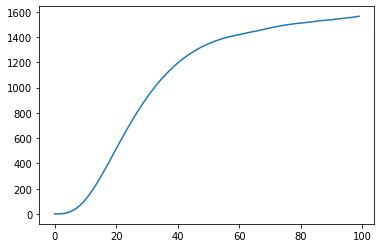

In [169]:
#Parece ser Glucosa: 3, 4, 12
#Parece ser CHO: 0, 1, 2, 
#Parece ser insulina: 5, 6, 7, 8, 9, 10, 11
plt.plot(states[:, 6])

In [146]:
1./max_norm

array([68000., 35000., 41000.,   230.,   100.,  3300., 75000., 28000.,
        6700.,  2300., 56000., 41000.,   230.])

In [28]:
info['patient_state']

array([ 6.03993974e+02,  2.97893579e+03,  2.26860714e+04, -4.72015312e-11,
       -5.78482032e-13,  2.72696993e+03,  6.88846483e+04,  6.06499559e+04,
        3.80137606e+04,  1.93044803e+03,  4.23219680e+04,  3.42723124e+04,
       -7.49470886e-13])

In [27]:
controlador.choose_action()

ctrller_action(basal=13.0, bolus=0)

# Probando con varias Simulaciones

In [44]:
from simglucose.simulation.user_interface import simulate
from simglucose.controller.base import Controller, Action
from simglucose.simulation.scenario_gen import RandomScenario

In [45]:
class rl_controller(Controller):
    def __init__(self, init_state, norm, max_action, num_actions):
        self.init_state = init_state
        self.state = init_state
        self.norm = norm
        self.max_action = max_action
        self.num_actions = num_actions

    def policy(self, observation, reward, done, **info):
        self.state = info['patient_state']
        
        action = self.choose_action()
        
        return action
    
    def choose_action(self):
        s = np.reshape(self.state, (1, -1))*self.norm
        ind = np.argmax(red.predict(s))
        a = self.convert_action(ind)
        action = Action(basal = a, bolus= 0)
        
        return action
        
    def convert_action(self, index):
        return index*self.max_action/float(self.num_actions)

    def reset(self):
        self.state = self.init_state
        
controlador = rl_controller(np.zeros((1,13)), max_norm, max_accion, num_acciones)

Show animation? (y/n) y
Use multiple processes? (y/n) n
Folder name to save results [default]: 
Results will be saved in /home/hero/Downloads/Uniandes/tesis2/results/2020-06-09_20-26-49
Input simulation time (hr): 8
Select scnenario:
[1] Random Scnenario
[2] Custom Scnenario
>>>1
Select random seed for random scenario [None]: 
Input simulation start time (hr): 8
Simulation start time is set to 2020-06-09 08:00:00.
Select virtual patients:
[1] All
[2] All Adolescents
[3] All Adults
[4] All Children
[5] By ID
>>> 3
Select the CGM sensor:
[1] Dexcom
[2] GuardianRT
[3] Navigator
>>> 1
Select Random Seed for Sensor Noise [None]: 
Select the insulin pump:
[1] Cozmo
[2] Insulet
>>> 1
Process ID: 14164
Simulation starts ...
Simulation Completed!
Process ID: 14164
Simulation starts ...
Simulation Completed!
Process ID: 14164
Simulation starts ...
Simulation Completed!
Process ID: 14164
Simulation starts ...
Simulation Completed!
Process ID: 14164
Simulation starts ...
Simulation Completed!
Proc

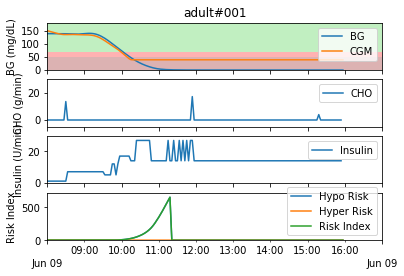

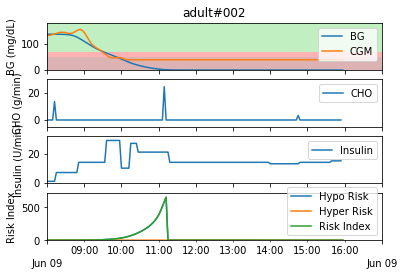

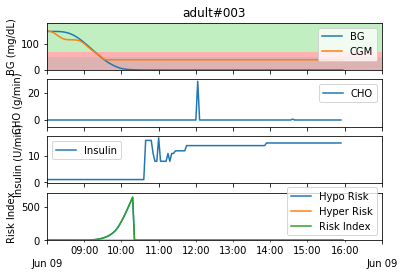

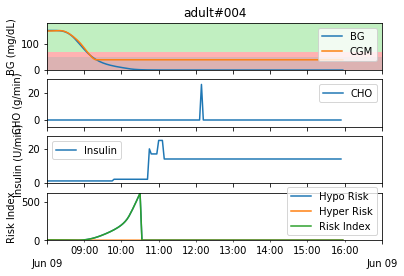

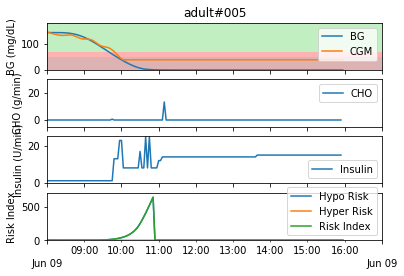

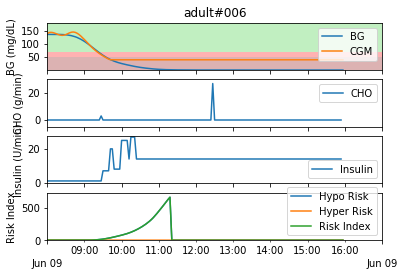

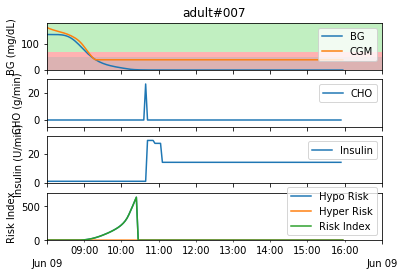

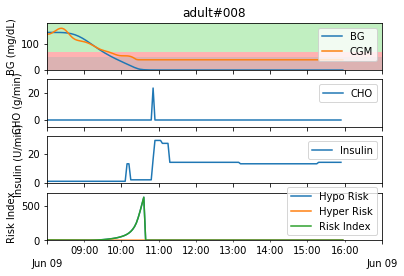

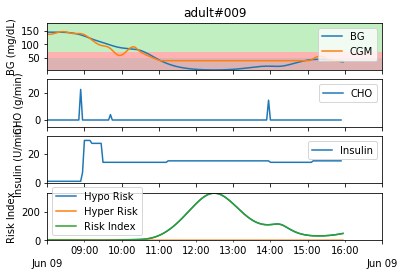

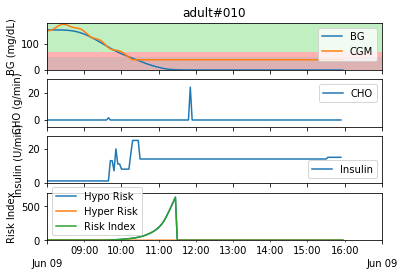

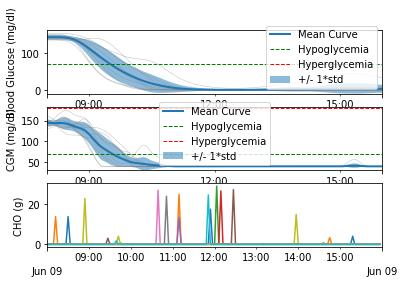

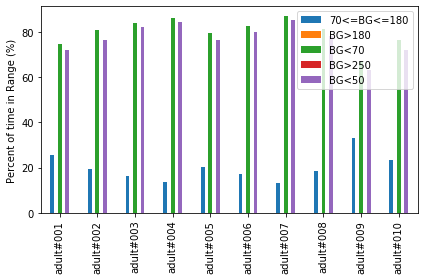

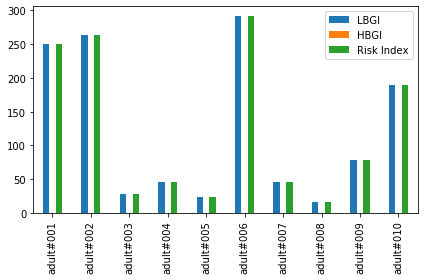

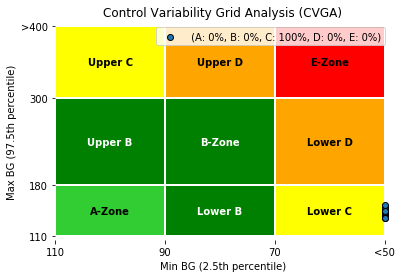

0

In [47]:
simulate(controller = controlador)

In [ ]:
controlador.policy(observation, reward, done, **info)

In [89]:
s = np.reshape(info['patient_state'], (1,-1))*max_norm
print(red.predict(s))

[[-0.9575964  -0.9542049  -0.95443046]]


In [45]:
print(keras.__version__)

2.3.1


In [93]:
a = convertirAccion(ind, max_accion, num_acciones)
print(a)

2.0


Input simulation start time (hr): 8
Simulation start time is set to 2020-06-09 08:00:00.
Input simulation time (hr): 8
Select virtual patients:
[1] All
[2] All Adolescents
[3] All Adults
[4] All Children
[5] By ID
>>> 1
Select the CGM sensor:
[1] Dexcom
[2] GuardianRT
[3] Navigator
>>> 1
Select Random Seed for Sensor Noise [None]: 
Select the insulin pump:
[1] Cozmo
[2] Insulet
>>> 1
Process ID: 14164
Simulation starts ...


KeyboardInterrupt: 

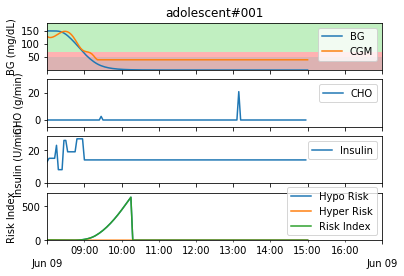

In [34]:
tiempo_simulacion = 1
escenario = RandomScenario()

fecha = datetime.datetime.now()
fecha = fecha.replace(hour = 8, minute = 0, second = 0, microsecond = 0)

ruta_resultados = "./results/simulations/" + fecha.strftime("%m/%d/%Y_%H:%M:%S")
animar = True

simulate(scenario = escenario, controller = controlador,
         save_path = ruta_resultados, animate = animar, parallel = False)

In [82]:
str(fecha)

'2020-05-19 08:00:00'

# Guardar las redes

In [54]:
def guardarModelo(pModelo, pRutaModelo):
    pModelo.save(pRutaModelo)

In [55]:
ruta_modelo = "./modelos/red_new_32.h5"
ruta_modelo_target = "./modelos/red_target_new_32.h5"

#Las red_new 5, 6 son las que mejor han funcionado
#La 8 es la segunda mejor hasta ahora.
#La 9 es la mejor hasta ahora.
#La 10 no sirve para nada
#La 11 no esta mal pero toca entrenar con mas steps (por ahi 200).
#La 12 aun no funciona bien. Entrenar mas.
#De la 14 en adelante ahora se entrena creando aleatoriamente el environment cada vez que lo reinicia.
#La 15 no está mal pero inyecta insulina cuando el azucar esta por debajo de maso 60 (yo creo que es
#por lo que el episodio termina ahi, entonces no logra aprender que no tiene que inyectar ahi. Puedo
#probar cambiando la reward function)
#La 16 es similar a la 15.
#La 17 es sin armar el estado al comienzo, sino que inicializandolo en valores constantes.
#La 18 usa la nueva funcion de reward. Se ve prometedora.
#La 19 va 32500 episodios.
#La 20 va 1000 episodios y tiene un estado con 80 valores.
#La 21 va 3000 episodios con un estado de 80 valores.
#La 22 va 2000 episodios con un estado de 120 valores
#La 24 es 15000 episodios con el nuevo estado de paciente.
#La 27 es 20000 episodios en el nuevo estado del paciente.
#La 28 apesta. Es 15000 episodios en el nuevo estado del paciente con 30 acciones.
#La 31 es la segunda mejor hasta ahora. Es 1000 episodios con estados del paciente con 30 acciones.
#La 32 es la mejor hasta ahora. Es 2000 episodios con estados del paciente con 30 acciones.

guardarModelo(red, ruta_modelo)
guardarModelo(red_target, ruta_modelo_target)

In [24]:
ruta_modelo = "./modelos/red_new_25.h5"
ruta_modelo_target = "./modelos/red_target_new_25.h5"

red = load_model(ruta_modelo)
red_target = load_model(ruta_modelo_target)

100% (200 of 200) |######################| Elapsed Time: 0:00:31 Time:  0:00:31


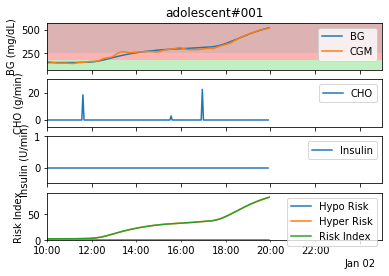

In [42]:
from gym.envs.registration import register
register(
    id='simglucose-adolescent2-v2',
    entry_point='simglucose.envs:T1DSimEnv',
    kwargs={'patient_name': 'adolescent#002'}
)

envName = 'simglucose-adolescent2-v2'
env = gym.make(envName) 

observation = env.reset()
for t in progressbar.progressbar(range(200)):
    env.render(mode='human')
    #print(observation)
    # Action in the gym environment is a scalar
    # representing the basal insulin, which differs from
    # the regular controller action outside the gym
    # environment (a tuple (basal, bolus)).
    # In the perfect situation, the agent should be able
    # to control the glucose only through basal instead
    # of asking patient to take bolus
    observation, reward, done, info = env.step(0)
    #if done:
    #    print("Episode finished after {} timesteps".format(t + 1))
    #    break

In [11]:
from simglucose.simulation.env import T1DSimEnv
from simglucose.controller.basal_bolus_ctrller import BBController
from simglucose.sensor.cgm import CGMSensor
from simglucose.actuator.pump import InsulinPump
from simglucose.patient.t1dpatient import T1DPatient
from simglucose.simulation.scenario_gen import RandomScenario
from simglucose.simulation.scenario import CustomScenario
from simglucose.simulation.sim_engine import SimObj, sim, batch_sim
from datetime import timedelta
from datetime import datetime

# specify start_time as the beginning of today
now = datetime.now()
start_time = datetime.combine(now.date(), datetime.min.time())

# --------- Create Random Scenario --------------
# Specify results saving path
path = './results'

# Create a simulation environment
patient = T1DPatient.withName('adolescent#001')
sensor = CGMSensor.withName('Dexcom', seed=1)
pump = InsulinPump.withName('Insulet')
scenario = RandomScenario(start_time=start_time, seed=1)
env = T1DSimEnv(patient, sensor, pump, scenario)

# Create a controller
controller = BBController()

# Put them together to create a simulation object
s1 = SimObj(env, controller, timedelta(days=1), animate=False, path=path)
results1 = sim(s1)
print(results1)

# --------- Create Custom Scenario --------------
# Create a simulation environment
patient = T1DPatient.withName('adolescent#001')
sensor = CGMSensor.withName('Dexcom', seed=1)
pump = InsulinPump.withName('Insulet')
# custom scenario is a list of tuples (time, meal_size)
scen = [(7, 45), (12, 70), (16, 15), (18, 80), (23, 10)]
scenario = CustomScenario(start_time=start_time, scenario=scen)
env = T1DSimEnv(patient, sensor, pump, scenario)

# Create a controller
controller = BBController()

# Put them together to create a simulation object
s2 = SimObj(env, controller, timedelta(days=1), animate=False, path=path)
results2 = sim(s2)
print(results2)


# --------- batch simulation --------------
# Re-initialize simulation objects
s1.reset()
s2.reset()

# create a list of SimObj, and call batch_sim
s = [s1, s2]
results = batch_sim(s, parallel=True)
print(results)

Process ID: 3218
Simulation starts ...
Simulation Completed!
                             BG         CGM  CHO   insulin  LBGI      HBGI  \
Time                                                                         
2020-02-07 00:00:00  149.020000  165.793949  0.0  0.013933   0.0  2.755276   
2020-02-07 00:03:00  149.020000  161.582022  0.0  0.013933   0.0  2.755276   
2020-02-07 00:06:00  149.020000  159.239373  0.0  0.013933   0.0  2.755276   
2020-02-07 00:09:00  149.020000  157.472710  0.0  0.013933   0.0  2.755276   
2020-02-07 00:12:00  149.020000  156.108950  0.0  0.013933   0.0  2.755276   
...                         ...         ...  ...       ...   ...       ...   
2020-02-07 23:48:00  140.377422  140.872461  0.0  0.013933   0.0  1.706344   
2020-02-07 23:51:00  139.944000  139.740305  0.0  0.013933   0.0  1.658886   
2020-02-07 23:54:00  139.528133  138.839245  0.0  0.013933   0.0  1.613846   
2020-02-07 23:57:00  139.128508  138.273393  0.0  0.013933   0.0  1.571027   
202